# **Usig Convolutional Neural Network (CNN) for image classification**

Intentaremos predecir una señal de tráfico a partir de su imagen. Para
esta tarea, utilizaremos una CNN (red neuronal convolucional), que es capaz de
explotar la correlación espacial entre píxeles cercanos en una imagen. Para ellos usamos la biblioteca **keras**

**Keras** es  model-level library, que proporciona componentes básicos de alto nivel para desarrollar modelos de **Deep Learning**.
 
No maneja por sí mismo operaciones de bajo nivel como productos tensoriales, convoluciones, etc. En cambio, se basa en una biblioteca de manipulación de tensores especializada y bien optimizada para hacerlo, que actúa como el **"motor de backend"** de Keras. En lugar de elegir una sola biblioteca de tensores y vincular la implementación de Keras a esa biblioteca, Keras maneja el problema de una manera modular, y varios **motores de backend** diferentes se pueden conectar sin problemas a Keras.

En este momento, **Keras** tiene dos implementaciones de backend disponibles: **el backend de TensorFlow** desarrollado por Google y **el backend de Theano** desarrallado por LISA/MILA Lab at Université de Montréal

In [1]:
import keras
keras.backend.backend()


'tensorflow'

Hemos elegido 32x32 píxeles como tamaño estándar: es pequeño pero suficiente para reconocer la señal y, al mismo tiempo, no requiere demasiada memoria (es decir, cada imagen en escala de grises utiliza sólo 1.024 bytes o 1
KB). Aumentar el tamaño significa aumentar la memoria necesaria para mantener
el conjunto de datos, además de la capa de entrada de la red profunda y el tiempo
necesario para los cálculos.
* En la literatura, 32x32 es una elección bastanteestándar para imágenes con un solo elemento

In [2]:
N_CLASSES = 43
# Resize all images to 32x32 because the original images are too big
RESIZED_IMAGE = (32, 32)


>**Leer las imágenes y redimensionarlas, creando la matriz de observación y la matriz de etiquetas**

1. Importa los módulos necesarios para el procesamiento.

2. Leemos las imágenes una tras otra. La etiqueta está contenida en la ruta. Por
ejemplo, la imagen *GTSRB/Final_Training/Images/00000/00003_00024.ppm* tiene la
etiqueta 00000, que es la clase 0;

3. La imagen se almacena en el **formato PPM (Portable PixMap)**, y es una forma
sin pérdidas de almacenar los píxeles de una imagen.Para leer ese formato se usa la función *imread*.El objeto devuelto es un array NumPy 3D.

4. La matriz NumPy 3D, que contiene la representación en píxeles de la imagen en RGB
(con tres canales: rojo, azul y verde) y  se convierte a escala de grises. Aquí,
primero convertimos al **espacio de color LAB** que es perceptualmente más lineal que otros, lo que implica que la misma cantidad de cambio en un valor de color debería producir un impacto de la
misma importancia visual), y luego se mantiene el primer canal (que contiene
la luminancia). Como resultado, tenemos una matriz NumPy 1D que contiene los píxeles de
la imagen.
5. Por último, la imagen se redimensiona al formato de 32x32 píxeles, de
nuevo mediante la función **resize()** de skimage.

6. Por último, todas las imágenes se comprimen en una matriz de 4
dimensiones: la primera dimensión se utiliza para indexar la imagen dentro
del conjunto de datos; la segunda y la tercera representan la altura y la
anchura de la imagen, respectivamente; y la última dimensión es el canal.
Teniendo 39.208 imágenes, con todos los píxeles de 32x32 en escala de
grises, la matriz de observación tiene, por tanto, la forma (39.208, 32, 32, 1).
7. Las etiquetas se compactan en una matriz bidimensional. La primera
dimensión es el índice de la imagen y la segunda la clase. Al tener el mismo
número de imágenes y 43 clases posibles, esta matriz tendrá la forma
(39,208, 43).

In [3]:
""" Read the images and resize them, creating the observation matrix and the array of labels"""

import matplotlib.pyplot as plt
import glob  # glob — Expansión del patrón de nombres de ruta de estilo Unix
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
%matplotlib inline

np.random.seed(101)

# crear una tupla con nombre  Dataset para las observaciones y las etiquetas
Dataset = namedtuple('Dataset', ['X', 'y'])


def to_tf_format(imgs):
    """Transform the array of images to the format used by tensorflow
       where wich row is a  image"""

    # np.newaxis crea una nueva dimensión
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)


def read_dataset_ppm(rootpath, n_labels, resize_to):
    images = []
    labels = []
    i = 0
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'

        # glob(path) encuentra todos los nombres de ruta que coinciden con un patrón específico
        for img_name in glob.glob(full_path + "*.ppm"):
            i = i+1
            # Read the image and convert it to LAB color space
            img = plt.imread(img_name).astype(np.float32)
            img = rgb2lab(img / 255.0)[:, :, 0]  # el primer canal (que contiene la luminoidad).

            if resize_to:
                img = resize(img, resize_to, mode='reflect', anti_aliasing=True)

            label = np.zeros((n_labels, ), dtype=np.float32)
            label[c] = 1.0
            images.append(img.astype(np.float32))
            labels.append(label)
    return Dataset(X=to_tf_format(images).astype(np.float32),
                   y=np.matrix(labels).astype(np.float32))


dataset = read_dataset_ppm('resources\GTSRB\Final_Training\Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)


(39209, 32, 32, 1)
(39209, 43)


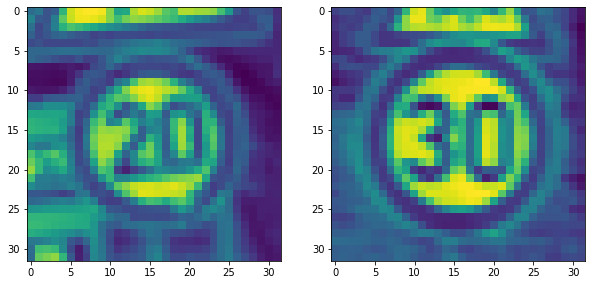

In [4]:
plt.figure(figsize=(10, 10))
fig = plt.subplot(1, 2, 1)
fig.imshow(dataset.X[10, :, :, :].reshape(RESIZED_IMAGE))
fig = plt.subplot(1, 2, 2)
fig.imshow(dataset.X[1000, :, :, :].reshape(RESIZED_IMAGE))


(1024, 1024, 3)


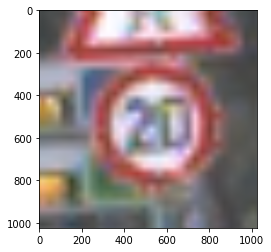

In [5]:
img = plt.imread('resources\GTSRB\Final_Training\Images/00000/00000_00001.ppm').astype(np.float32)
# img = rgb2lab(img/255.0 )[:, :, 0] #  el primer canal (que contiene la luminoidad).
# plt.figure(figsize=(10,10))
img = img/255.0
img = resize(img, (1024, 1024), mode='reflect', anti_aliasing=True)
plt.imshow(img[:, :, :])
print(img.shape)


---
Split the dataset into training and testing using Scikit-learn to randomly
separate and shuffle the images. In this cell, we select 25% of the dataset as a test
set; that is, almost 10,000 images, leaving the other 29K+ images for training the
deep network:

In [6]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25,
                                       random_state=101)

X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


Creating **deep nets** with **Keras** is very easy: you have to define all layers in a
sequential way , one after another . The Keras object needs to define the layers in a
sequence named **Sequential**. Here, we will create a deep net with three layers:

1. The input layer, defined as a convolutional 2D layer (which is actually a
convolutional operation between the image and the kernel), contains 32 filters
in the shape of 3x3 pixels and with an activation layer of type ReLU.
2. A layer that flattens(aplanamiento) the output of the previous; that is, square observations will
be unrolled to create a 1D array .
3.  A dense output layer , with softmax activation and which is composed of 43
units, one for each class.

The model is then compiled and, finally , fitted to the training data. During this
operation we selected the following:

* The loss function: Cross Entropy
* The optimizer: SGD, the simplest one
* The batch size: 32 images/batch
* The numbers of epochs: 10

In [7]:
from keras.models import Sequential

from keras.layers.core import Dense  # units fully connected
from keras.layers.core import Flatten   # units for flatten(aplanar)
from keras.layers.convolutional import Conv2D  # units of convolutional layers
from keras.optimizers import SGD
from keras import backend as K

# definir que el formato de la imagen tiene los channels al final (por defecto es 'channels_first' )
K.set_image_data_format('channels_last')


def cnn_model_1():
    model = Sequential()

    model.add(Conv2D(32, (3, 3),
                     padding='same',
                     input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model


cnn = cnn_model_1()
cnn.compile(loss='categorical_crossentropy',
            optimizer=SGD(learning_rate=0.001, decay=1e-6),
            metrics=['accuracy'])
print(X_train.shape)
cnn.fit(X_train,
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test))


(29406, 32, 32, 1)
Epoch 1/10
919/919 [==============================] - 16s 15ms/step - loss: 2.0745 - accuracy: 0.6069 - val_loss: 0.7048 - val_accuracy: 0.8429
Epoch 2/10
919/919 [==============================] - 14s 15ms/step - loss: 0.5473 - accuracy: 0.8810 - val_loss: 0.5947 - val_accuracy: 0.8597
Epoch 3/10
919/919 [==============================] - 14s 15ms/step - loss: 0.3555 - accuracy: 0.9230 - val_loss: 0.3697 - val_accuracy: 0.9220
Epoch 4/10
919/919 [==============================] - 14s 15ms/step - loss: 0.2555 - accuracy: 0.9457 - val_loss: 0.4848 - val_accuracy: 0.9118
Epoch 5/10
919/919 [==============================] - 16s 17ms/step - loss: 0.2045 - accuracy: 0.9587 - val_loss: 0.2847 - val_accuracy: 0.9378
Epoch 6/10
919/919 [==============================] - 14s 15ms/step - loss: 0.1654 - accuracy: 0.9651 - val_loss: 0.2781 - val_accuracy: 0.9429
Epoch 7/10
919/919 [==============================] - 14s 15ms/step - loss: 0.1325 - accuracy: 0.9723 - val_loss: 0.2

* La primera capa que es la convolucional tendra 32 filtros de (3x3) mas un sesgo por cada filtro seria un total de 320 parametros que aprender
* La segunda capa no tiene parametros que es soolo de aplanamiento
* La 3era capa de Fully Connected tiene 43 unidades y la salida de la capa anterior tiene dimensiones (32 x 32 x 32) (kernel x heigth x width) = 32 768 y como cada salida tiene que ir a cada unidad y ademas cada unidad tiene un sesgo 43 * (32 x 32 x 32) + 43 =  1 409 067 parametros en esta 3era capa
 
> Lo que da un total de **1 409 387** parámetros para una red bastante sencilla. 

In [8]:
cnn.count_params()


1409387

La precisión final se acerca al 99% en el conjunto de entrenamiento y casi al 96%
en el conjunto de prueba. Estamos sobreajustando un poco, pero veamos la matriz
de confusión y el informe de clasificación de este modelo en el conjunto de
prueba. También imprimiremos **log2** de la matriz de confusión para identificar
mejor los errores de clasificación.

307/307 [==============================] - 2s 5ms/step
sum_supoort 9803


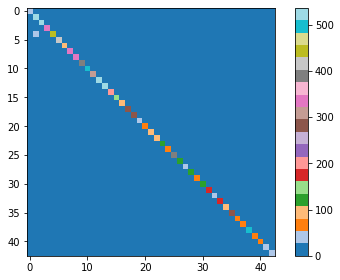

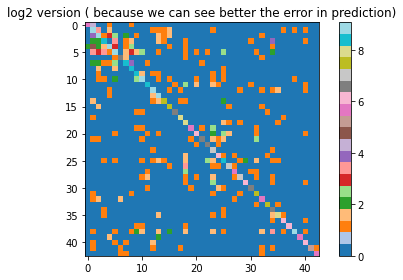

In [58]:
from sklearn.metrics import classification_report, confusion_matrix


def test_and_plot(model, X, y):
    y_pred = model.predict(X)
    y_pred_softmax = np.argmax(y_pred, axis=1).astype(np.int32)
    y_test_softmax = np.argmax(y, axis=1).astype(np.int32)

    cr = classification_report(y_test_softmax, y_pred_softmax, output_dict=True)
    print('sum_supoort', np.array([cr['' + str(i)].get('support') for i in range(43)]).sum())
    # print(classification_report(y_test_softmax, y_pred_softmax))

    cm = confusion_matrix(y_test_softmax, y_pred_softmax)
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap("tab20"))
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # And the log2 version, to emphasize the misclassifications
    # plt.figure(figsize=(10, 10))  # para ver mas grande la figura
    plt.imshow(np.log2(cm + 1), interpolation='nearest',  cmap=plt.get_cmap("tab20"))
    plt.title("log2 version ( because we can see better the error in prediction)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


test_and_plot(cnn, X_test, y_test)


## Para mejorar el modelo podemos utilizar:
* **Dropout(descartar) layers** : Es el equivalente a la regularización y evita el sobreajuste.
Básicamente, en cada paso del entrenamiento se desactiva una parte de las
unidades, para que la salida de la capa no dependa demasiado de unas pocas.
 
* **BatchNormalization layer**: Esto z-normaliza la capa, restando la media del lote y
dividiéndola por la desviación estándar. Es útil para recentrar los datos, y
amplifica/atenúa la señal en cada paso.
 
* **MaxPooling**: Se trata de una transformación no lineal, que se utiliza para
reducir la muestra de entrada aplicando un filtro max a cada región bajo el
kernel. Se utiliza para seleccionar la característica máxima, que puede estar
en una posición ligeramente diferente dentro de la misma clase.

Más allá de esto, siempre hay espacio para cambiar la red profunda y las
propiedades de entrenamiento; es decir, el optimizador (y sus parámetros), el
tamaño del lote y el número de epoach(iteraciones)

## Improved(mejorada) CNN with the following layers:

1. **Convolutional layer**, with 32 3x3 filters and ReLU activation:  32 filtros de (3x3) mas un sesgo por cada filtro seria un total de **320** en esta capa
 
2. *BatchNormalization* layer : tiene 4 parametros por cada neurona de la capa anterior es decir 32x4 = **128**
3. Another **convolutional layer** followed by a **BatchNormalization** layer:  32 filtros de (3x3) por cada salida de la capa anterior ( 32 caracteristcas) mas un sesgo por cada filtro 32 x (3x3) x 32 + 32 = **9248** y **128** = 4x32 parametros de la capa de BatchNormaliztion 
4. **MaxPooling**, with dimension of (2x2): no tiene paramentros que aprender pero reduce la dimension a (32 x 16 x 16)
5. **Dropout layer**, with a probability of 0.4 of being dropped
6. **Flattening layer**: devulve una matriz plana de 8192 = (32 x 16 x 16)
7. 512-units *dense layer*, with ReLU activation: 8192 * 512 + 512 = **4 194 816** parámetros
8. **BatchNormalization layer** : 512 * 4 = **2048** parametros
9. **Dropout layer**, with a probability of 0.5 of being dropped
10. **A Dense Output layer**; with 43 units and softmax activation : 43 * 512 + 43 = **22 059** parámetros

In [61]:
from keras.models import Sequential
from keras import backend as K


from keras.layers.core import Dense  # units fully connected
from keras.layers.core import Dropout   # Applies Dropout to the out of the past layer
from keras.layers.core import Flatten   # units for flatten(aplanar)
from keras.layers.convolutional import Conv2D  # units of convolutional layers
from keras.layers import BatchNormalization    # units of z-normalization at the batch
from keras.layers.pooling import MaxPooling2D   # units of Pooling(Agrupacion)

from keras.optimizers import Adam  # SGD based of first-order and second-order moments.


def cnn_model_2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3),
                     padding='same',
                     input_shape=(RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model


cnn = cnn_model_2()
cnn.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])
cnn.fit(X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test))


Epoch 1/10
919/919 [==============================] - 95s 102ms/step - loss: 0.7450 - accuracy: 0.8069 - val_loss: 0.1639 - val_accuracy: 0.9577
Epoch 2/10
919/919 [==============================] - 98s 107ms/step - loss: 0.1440 - accuracy: 0.9587 - val_loss: 0.0718 - val_accuracy: 0.9779
Epoch 3/10
919/919 [==============================] - 97s 106ms/step - loss: 0.1215 - accuracy: 0.9636 - val_loss: 0.1149 - val_accuracy: 0.9652
Epoch 4/10
919/919 [==============================] - 90s 98ms/step - loss: 0.0768 - accuracy: 0.9767 - val_loss: 0.0546 - val_accuracy: 0.9855
Epoch 5/10
919/919 [==============================] - 93s 101ms/step - loss: 0.0557 - accuracy: 0.9821 - val_loss: 0.0537 - val_accuracy: 0.9852
Epoch 6/10
919/919 [==============================] - 94s 102ms/step - loss: 0.0744 - accuracy: 0.9763 - val_loss: 0.0642 - val_accuracy: 0.9829
Epoch 7/10
919/919 [==============================] - 95s 104ms/step - loss: 0.0520 - accuracy: 0.9827 - val_loss: 0.0545 - val_acc

La precisión del conjunto de entrenamiento es similar a la del conjunto de prueba,
y ambas rondan el 99%. Esta red es más larga y requiere más memoria y potencia de
cálculo, pero es **menos propensa al sobreajuste** y rinde mejor.

In [99]:
print("total de parametros de la red: ",cnn.count_params())


total de parametros de la red:  4228747
